# Installation

In [1]:
  !pip install gdown datasets evaluate
  !pip install transformers datasets scikit-learn torch

# Import RoBERTa

In [2]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

model_name = "s-nlp/roberta_toxicity_classifier"
tokenizer = RobertaTokenizer.from_pretrained('s-nlp/roberta_toxicity_classifier')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Data Prep

In [3]:
!pip install gdown
file_id = "1hDhldzGy2QCIuBlNWy2TF4uB1HtoTKK0"

!gdown {file_id}

Downloading...
From: https://drive.google.com/uc?id=1hDhldzGy2QCIuBlNWy2TF4uB1HtoTKK0
To: /content/toxic_comment_dataset6k.csv
100% 638k/638k [00:00<00:00, 30.8MB/s]


In [4]:
import pandas as pd
from datasets import Dataset

df = pd.read_csv("toxic_comment_dataset6k.csv")
dataset = Dataset.from_pandas(df)

In [5]:
df

,Toxic Comment,Classification,Detoxified Version
0,i'll fucking hit you,Threat,i'll hit you
1,that bitch is an idiot,Insult,that girl is not quite smart
2,go kill yourself loser,Threat,you should reconsider your actions
3,who let this retard in here,Insult,who allowed this inexperienced person in
4,I'll break your damn legs,Threat,I might have to stop you physically
...,...,...,...
7384,i'd love to see you in a swimsuit,Sexual Harassment,your appearance in specific attire interests me
7385,no wonder your team always fails,Insult,your group's inadequacy seems explicable
7386,one day when you least expect it,Threat,consequences may arrive during periods of low ...
7387,those eyes make me think of bedroom activities,Sexual Harassment,your visual organs suggest intimate contexts


In [6]:
# Label mapping
label_map = {"Threat": 0, "Insult": 1, "Sexual Harassment": 2, "Non-Toxic": 3}

# Data toxic
df_toxic = df[["Toxic Comment", "Classification"]].rename(columns={"Toxic Comment": "text", "Classification": "label"})

# Data detoxified become non-toxic
df_nontoxic = df[["Detoxified Version"]].rename(columns={"Detoxified Version": "text"})
df_nontoxic["label"] = "Non-Toxic"

# Merge
df_combined = pd.concat([df_toxic, df_nontoxic], ignore_index=True)

# Shuffle combined dataset
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# Change label to integer map
df_combined["label"] = df_combined["label"].map(label_map)

In [7]:
df_combined

,text,label
0,I prefer different delivery personnel,3
1,I believe you're fundamentally incapable,3
2,u seem like u want some fun,2
3,those yoga pants show everything nice,2
4,Continuing to speak might lead to physical har...,3
...,...,...
14773,that body got me actin up,2
14774,I'd like close physical contact,3
14775,giving major virgin energy,1
14776,I'll shoot you between the fucking eyes,0


# Tokenize

In [8]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

train_df, val_df = train_test_split(df_combined, test_size=0.2, random_state=42)
train_df.reset_index(drop=True)
val_df.reset_index(drop=True)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

dataset = DatasetDict(
    {
        "train": train_dataset,
        "val": val_dataset
    })

In [9]:
def tokenize_function(examples):
    tokenized_inputs = tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=64
    )
    tokenized_inputs["labels"] = examples["label"]
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=train_dataset.column_names)

Map:   0%|          | 0/11822 [00:00<?, ? examples/s]

Map:   0%|          | 0/2956 [00:00<?, ? examples/s]

In [10]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 11822
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2956
    })
})

# Training and Defining Evaluation Metrics

In [11]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="weighted")
    }


In [12]:
from transformers import DataCollatorWithPadding

model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=4,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3,
    ignore_mismatched_sizes=True
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of the model checkpoint at s-nlp/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at s-nlp/roberta_toxicity_classifier and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) i

In [13]:
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

# Compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision.compute(predictions=predictions, references=labels, average="weighted")["precision"],
        "recall": recall.compute(predictions=predictions, references=labels, average="weighted")["recall"],
        "f1": f1.compute(predictions=predictions, references=labels, average="weighted")["f1"],
    }

In [14]:
from transformers import TrainingArguments, Trainer
import torch

training_args = TrainingArguments(
    output_dir="test-trainer",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    fp16=True,
    weight_decay = 0.01,
    report_to="none"
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [16]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-16-c4a251071bc6>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [17]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.288700,0.206698,0.955007,0.955627,0.955007,0.954819
2,0.129500,0.181383,0.967185,0.967885,0.967185,0.967199
3,0.072200,0.183093,0.965832,0.966164,0.965832,0.965914
4,0.033300,0.173421,0.972936,0.973033,0.972936,0.972898
5,0.015800,0.170326,0.973951,0.974026,0.973951,0.973942


TrainOutput(global_step=3695, training_loss=0.1078966705982998, metrics={'train_runtime': 402.7764, 'train_samples_per_second': 146.756, 'train_steps_per_second': 9.174, 'total_flos': 1944096720184320.0, 'train_loss': 0.1078966705982998, 'epoch': 5.0})

# Saving Model

In [18]:
# Save model and tokenizer
output_dir = "./saved_model_roberta_toxic"

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)



print(f"Model saved Successfully!: {output_dir}")


Model saved Successfully!: ./saved_model_roberta_toxic


In [19]:
!zip -r saved_model_roberta_toxic.zip saved_model_roberta_toxic/


updating: saved_model_roberta_toxic/ (stored 0%)
updating: saved_model_roberta_toxic/tokenizer_config.json (deflated 76%)
updating: saved_model_roberta_toxic/model.safetensors (deflated 7%)
updating: saved_model_roberta_toxic/special_tokens_map.json (deflated 84%)
updating: saved_model_roberta_toxic/config.json (deflated 53%)
updating: saved_model_roberta_toxic/merges.txt (deflated 53%)
updating: saved_model_roberta_toxic/vocab.json (deflated 68%)


# Training Evaluation Visuals

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from tqdm import tqdm
import pandas as pd

# 1. Extract and visualize training metrics
def plot_training_metrics(trainer):
    """Plot training metrics from the Trainer's state"""
    # Extract metrics from the training logs
    train_metrics = {
        'train_loss': [],
        'eval_loss': [],
        'eval_accuracy': [],
        'eval_precision': [],
        'eval_recall': [],
        'eval_f1': [],
        'epochs': []
    }

    epoch = 0
    for log in trainer.state.log_history:
        if 'loss' in log and 'eval_loss' not in log:
            train_metrics['train_loss'].append(log['loss'])
        elif 'eval_loss' in log:
            train_metrics['eval_loss'].append(log['eval_loss'])
            train_metrics['eval_accuracy'].append(log['eval_accuracy'])
            train_metrics['eval_precision'].append(log['eval_precision'])
            train_metrics['eval_recall'].append(log['eval_recall'])
            train_metrics['eval_f1'].append(log['eval_f1'])
            train_metrics['epochs'].append(epoch)
            epoch += 1

    # Create visualization plots
    plt.figure(figsize=(15, 12))

    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(train_metrics['epochs'], train_metrics['eval_loss'], 'o-', label='Validation Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot accuracy
    plt.subplot(2, 2, 2)
    plt.plot(train_metrics['epochs'], train_metrics['eval_accuracy'], 'o-', label='Accuracy', color='green')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Plot precision, recall, f1
    plt.subplot(2, 2, 3)
    plt.plot(train_metrics['epochs'], train_metrics['eval_precision'], 'o-', label='Precision', color='blue')
    plt.plot(train_metrics['epochs'], train_metrics['eval_recall'], 'o-', label='Recall', color='orange')
    plt.plot(train_metrics['epochs'], train_metrics['eval_f1'], 'o-', label='F1', color='red')
    plt.title('Validation Precision, Recall, F1')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

    plt.show()

    # Return metrics for further analysis
    return train_metrics

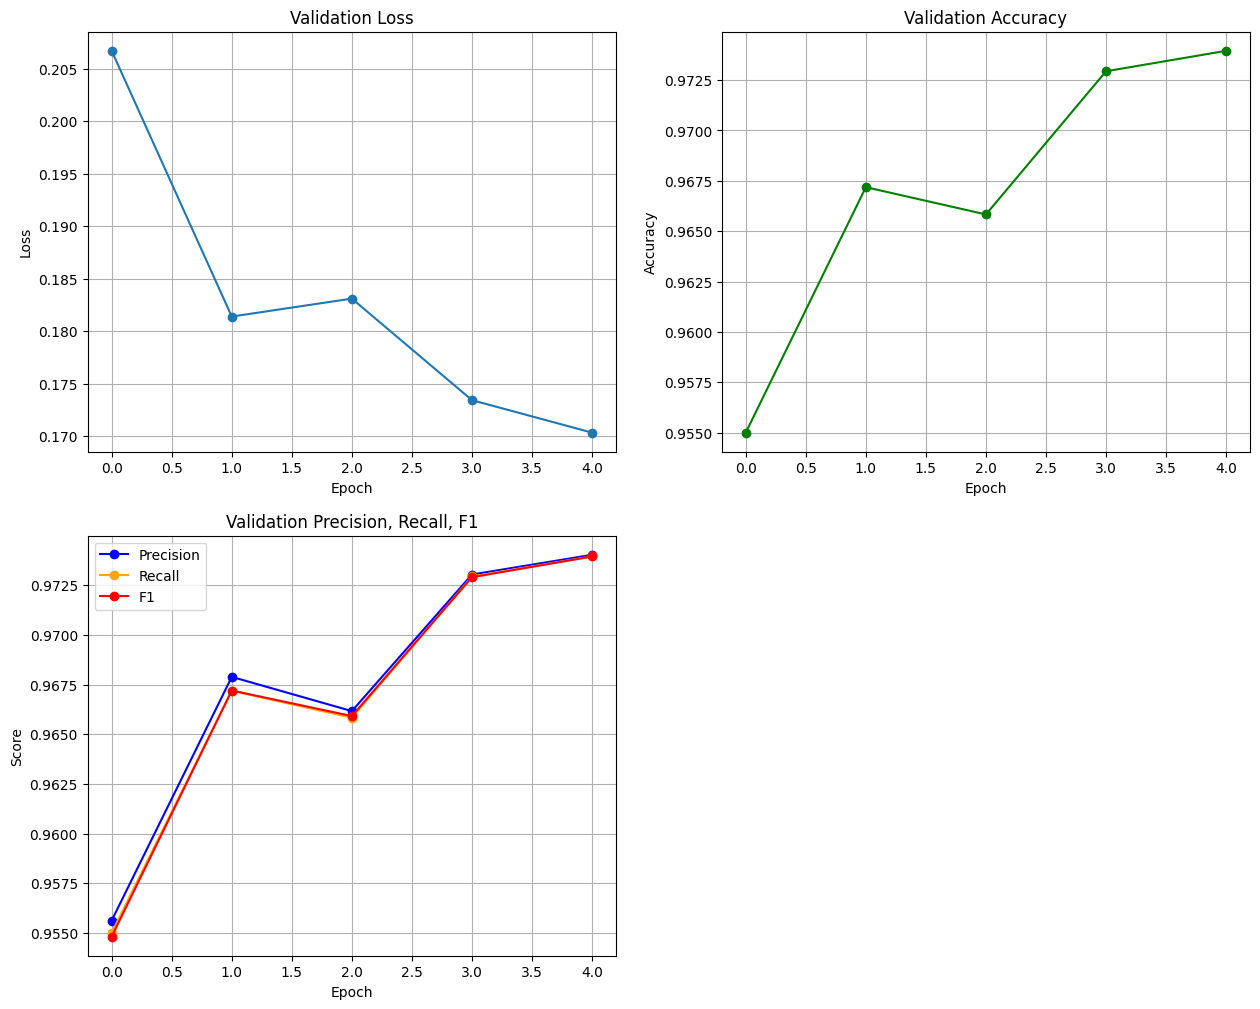

In [21]:
metrics = plot_training_metrics(trainer)

# Testing

In [26]:
import re

# Abbreviation
abbreviation_dict = {
    "u": "you", "ur": "your", "r": "are", "idk": "i don't know",
    "btw": "by the way", "lol": "laughing out loud", "lmao": "laughing my ass off",
    "pls": "please", "plz": "please", "thx": "thanks", "ty": "thank you", "np": "no problem",
    "imo": "in my opinion", "imho": "in my humble opinion", "brb": "be right back",
    "bbl": "be back later", "ttyl": "talk to you later", "afaik": "as far as i know",
    "fyi": "for your information", "asap": "as soon as possible", "smh": "shaking my head",
    "tbh": "to be honest", "ikr": "i know right", "wtf": "what the fuck", "wth": "what the hell",
    "bff": "best friends forever", "omw": "on my way", "gonna": "going to", "wanna": "want to",
    "gotta": "got to", "ain't": "is not", "cuz": "because", "cause": "because", "ya": "you",
    "nah": "no", "yea": "yes", "lmk": "let me know", "kys": "kill yourself", "omg": "shocked",
    "bc": "because", "tho": "though", "idc": "i don't care", "ily": "i love you", "nvm": "never mind",
    "jk": "just kidding", "hbu": "how about you", "wyd": "what are you doing", "wbu": "what about you",
    "tbf": "to be fair", "rn": "right now", "ttys": "talk to you soon", "ilysm": "i love you so much",
    "bday": "birthday", "bcuz": "because", "sup": "what's up", "yolo": "you only live once",
    "bf": "boyfriend", "gf": "girlfriend", "thxsm": "thank you so much", "gr8": "great", "sry": "sorry",
    "g2g": "got to go", "hmu": "hit me up", "msg": "message", "dm": "direct message", "irl": "in real life",
    "xoxo": "hugs and kisses", "xo": "hugs and kisses", "b4": "before", "bcz": "because", "k": "okay",
    "okie": "okay", "okies": "okay", "tmrw": "tomorrow", "luv": "love", "hi": "hello",
    "bae": "before anyone else", "bruh": "brother", "cya": "see you", "ded": "dead", "derp": "stupid",
    "ez": "easy", "ffs": "for fuck's sake", "ftw": "for the win", "gg": "good game", "gtg": "got to go",
    "icymi": "in case you missed it", "jkz": "just kidding", "naw": "no", "ngl": "not gonna lie",
    "oof": "ouch", "rofl": "rolling on the floor laughing", "sksksk": "laughing", "snm": "say no more",
    "srsl": "seriously", "stfu": "shut the fuck up", "tfw": "that feeling when", "tldr": "too long didn't read",
    "tysm": "thank you so much", "urself": "yourself", "wassup": "what is up", "wuz": "was",
    "ya'll": "you all", "yw": "you're welcome", "zomg": "shocked"
}

# abbreviation subtitute
def replace_abbreviations(text, abbreviation_dict):
    pattern = r'\b(' + '|'.join(re.escape(key) for key in abbreviation_dict) + r')\b'
    return re.sub(pattern, lambda x: abbreviation_dict[x.group()], text.lower())

# Classiffication function
def classify_text_batch(text_list):
    # Normalization
    normalized_texts = [replace_abbreviations(text, abbreviation_dict) for text in text_list]

    # Batch Tokenizing
    inputs = tokenizer(normalized_texts, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {key: val.to("cuda") for key, val in inputs.items()}

    # Predicting
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=1).cpu().tolist()

    # Mapping label
    label_mapping = {0: "Threat", 1: "Insult", 2: "Sexual Harassment", 3: "Non-Toxic"}
    return [label_mapping[pred] for pred in predictions]

custom_texts = [
    "damn you're annoying",
    "i will kill you",
    "she looks nice today",
    "you suck",
    "wyd rn? u so annoying lol",
    "hi",
    "hello",
    "kys",
    "this pipeline is paralleling an existing pipeline that has been in operations for decades . i remember hearing push back from elementary school parents , but the high school parents i encountered were enthusiastic , as were the students for obvious reasons . that huge increase is a direct result of legalization .",
    "which squirrel do you want to chase ? . go look at order of nine angles . please cite examples of there being a plan or efforts to carry out your accusation .",
    "back in the 1980s the interest rate got close to and they still managed to churn stuff out . jesus wanted them to believe in him . support per the economist style guide : use english forms when they are in common use : cologne , leghorn , lower saxony , lyons , marseilles , naples , nuremberg , turin .",
    "I wish you a wonderful day",
    "Happy anniversary",
    "amazing work, kudos to you",
    "fuck nigga bitch noob shit black fuck nigga bitch noob shit black fuck nigga bitch noob shit black fuck nigga bitch noob shit black fuck nigga bitch noob shit black fuck nigga bitch noob shit black",
    "normal people do not label others as mogrels .",
    "it is because people get focused on their lives .",
    "i wish every year i could work the system better .",
    "honestly , like grated parmesan and DIGIT day old muffins .",
    "Lebron is the goat",
    "hey",
    "KCV is the best laboratory",
    "My name is Andrew and i like to sleep early"

]

predicted_labels = classify_text_batch(custom_texts)

for text, label in zip(custom_texts, predicted_labels):
    print(f"🔍 Input: {text}")
    print(f"📌 Predicted Label: {label}\n")


🔍 Input: damn you're annoying
📌 Predicted Label: Insult

🔍 Input: i will kill you
📌 Predicted Label: Threat

🔍 Input: she looks nice today
📌 Predicted Label: Non-Toxic

🔍 Input: you suck
📌 Predicted Label: Insult

🔍 Input: wyd rn? u so annoying lol
📌 Predicted Label: Insult

🔍 Input: hi
📌 Predicted Label: Non-Toxic

🔍 Input: hello
📌 Predicted Label: Non-Toxic

🔍 Input: kys
📌 Predicted Label: Threat

🔍 Input: this pipeline is paralleling an existing pipeline that has been in operations for decades . i remember hearing push back from elementary school parents , but the high school parents i encountered were enthusiastic , as were the students for obvious reasons . that huge increase is a direct result of legalization .
📌 Predicted Label: Non-Toxic

🔍 Input: which squirrel do you want to chase ? . go look at order of nine angles . please cite examples of there being a plan or efforts to carry out your accusation .
📌 Predicted Label: Sexual Harassment

🔍 Input: back in the 1980s the intere